In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import optuna
from joblib import dump, load
import shap


In [20]:
## Functions 
def evaluate_linear_baseline(data, base_features, max_degree=2, combo_size=5):
    results = []

    # Crear bloques temporales
    all_weeks = sorted(data['week'].dropna().unique())
    week_blocks = [all_weeks[i:i+5] for i in range(0, len(all_weeks), 5)]

    # Probar combinaciones de variables
    for feature_combo in combinations(base_features, combo_size):
        feature_combo = list(feature_combo)

        for degree in range(1, max_degree+1):
            rmses_train, rmses_test, corrs_train, corrs_test = [], [], [], []

            for week_block in week_blocks:
                fold_test = data[data['week'].isin(week_block)].copy()
                fold_train = data[~data['week'].isin(week_block)].copy()

                if fold_test.empty or fold_train.empty:
                    continue

                try:
                    # Subset y eliminar NaNs
                    train_subset = fold_train[feature_combo + ['Tmin']].dropna()
                    test_subset = fold_test[feature_combo + ['Tmin']].dropna()

                    if train_subset.empty or test_subset.empty:
                        continue

                    # Separar X e y
                    X_train_raw = train_subset[feature_combo]
                    y_train = train_subset['Tmin']

                    X_test_raw = test_subset[feature_combo]
                    y_test = test_subset['Tmin']

                    # Transformaciones polinómicas
                    poly = PolynomialFeatures(degree=degree, include_bias=False)
                    X_train = poly.fit_transform(X_train_raw)
                    X_test = poly.transform(X_test_raw)
                    
                    

                    # Entrenar modelo
                    model_linear = LinearRegression()
                    
                    model_linear.fit(X_train, y_train)

                    # Predicciones
                    preds_train = model_linear.predict(X_train)
                    preds_test = model_linear.predict(X_test)

                    # RMSE
                    rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
                    rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))

                    # Correlaciones protegidas
                    valid_train = ~np.isnan(y_train) & ~np.isnan(preds_train)
                    valid_test = ~np.isnan(y_test) & ~np.isnan(preds_test)

                    corr_train = pearsonr(y_train[valid_train], preds_train[valid_train])[0] if valid_train.sum() > 1 else np.nan
                    corr_test = pearsonr(y_test[valid_test], preds_test[valid_test])[0] if valid_test.sum() > 1 else np.nan

                    # Guardar métricas
                    rmses_train.append(rmse_train)
                    rmses_test.append(rmse_test)
                    corrs_train.append(corr_train)
                    corrs_test.append(corr_test)

                except Exception as e:
                    # Salta bloque si algo falla (opcional)
                    print(f"[WARN] Falló combo {feature_combo} con grado {degree}: {e}")
                    continue

            # Guardar resumen del fold
            results.append({
                'features': feature_combo,
                'degree': degree,
                'rmse_train': np.nanmean(rmses_train),
                'rmse_test': np.nanmean(rmses_test),
                'corr_train': np.nanmean(corrs_train),
                'corr_test': np.nanmean(corrs_test)
            })

    return pd.DataFrame(results)



def evaluate_model(trial):
    import warnings
    warnings.filterwarnings("ignore")
    from scipy.stats import pearsonr

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 70, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "max_delta_step": trial.suggest_int("max_delta_step", 3, 6),
        "gamma": trial.suggest_float("gamma", 2, 20),
        "min_child_weight": trial.suggest_int("min_child_weight", 5, 40),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.001, 10, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.001, 10, log=True),
        "random_state": 50,
        "n_jobs": -1
    }

    rmses_test = []
    rmses_train = []
    cor_test = []
    cor_train = []

    # Crear bloques temporales de 5 semanas
    all_weeks = sorted(df['week'].dropna().unique())
    week_blocks = [all_weeks[i:i+5] for i in range(0, len(all_weeks), 5)]

    for week_block in week_blocks:
        # Usar TODAS las estaciones en cada fold
        fold_test = df[df['week'].isin(week_block)].copy()
        fold_train = df[~df['week'].isin(week_block)].copy()

        if fold_test.empty or fold_train.empty:
            continue

        model = XGBRegressor(**params)
        model.fit(
            fold_train[features],
            fold_train['Tmin'],
            sample_weight=fold_train['sample_weight']
        )
        
        # Predicciones
        preds_test = model.predict(fold_test[features])
        preds_train = model.predict(fold_train[features])

        # RMSE
        rmse_test = np.sqrt(mean_squared_error(fold_test['Tmin'], preds_test))
        rmse_train = np.sqrt(mean_squared_error(fold_train['Tmin'], preds_train))

        # Correlaciones protegidas
        valid_train = ~fold_train['Tmin'].isna() & ~np.isnan(preds_train)
        valid_test = ~fold_test['Tmin'].isna() & ~np.isnan(preds_test)

        if valid_train.sum() > 1:
            corr_train = pearsonr(fold_train.loc[valid_train, 'Tmin'], preds_train[valid_train])[0]
        else:
            corr_train = np.nan

        if valid_test.sum() > 1:
            corr_test = pearsonr(fold_test.loc[valid_test, 'Tmin'], preds_test[valid_test])[0]
        else:
            corr_test = np.nan

        # Guardar métricas
        rmses_train.append(rmse_train)
        rmses_test.append(rmse_test)
        cor_train.append(corr_train)
        cor_test.append(corr_test)

    print(f"RMSE Train: {np.nanmean(rmses_train):.3f} | Pearson Train: {np.nanmean(cor_train):.3f}")
    print(f"RMSE Test:  {np.nanmean(rmses_test):.3f} | Pearson Test:  {np.nanmean(cor_test):.3f}")

    return np.nanmean(rmses_test) + 0.5 * abs(np.nanmean(rmses_test) - np.nanmean(rmses_train))



In [4]:
df = pd.read_parquet("D:/OneDrive - CGIAR/Desktop/downscaling/data/features/tmin_features.parquet")
df.shape

(1418, 17)

## Regresión Lineal 

In [8]:
def make_weights(y):
    y_centered = y - y.mean()
    return 1 + (y_centered / y_centered.std())**2

df['sample_weight'] = make_weights(df['Tmin'])

# Crear week_sin y week_cos
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

In [9]:
# Seleccionar subconjunto de variables relevantes
base_vars = ['tmax_saga', 'tmin_saga', 'slope', 'aspect', 'tpi', 'cumbre', 'valle', 'rugosity', 'dem', 'ndvi']
# Evaluar
resultados_baseline = evaluate_linear_baseline(df, base_vars, max_degree=2, combo_size=5)

# Ver los mejores resultados ordenados
resultados_baseline.sort_values(by='rmse_test').head(10)

,features,degree,rmse_train,rmse_test,corr_train,corr_test
25,"[tmax_saga, tmin_saga, slope, cumbre, rugosity]",2,0.781616,0.781610,0.889936,0.891007
27,"[tmax_saga, tmin_saga, slope, cumbre, dem]",2,0.782837,0.782193,0.889572,0.890616
1,"[tmax_saga, tmin_saga, slope, aspect, tpi]",2,0.780376,0.783172,0.890308,0.890724
61,"[tmax_saga, tmin_saga, aspect, valle, rugosity]",2,0.780347,0.783243,0.890317,0.890714
63,"[tmax_saga, tmin_saga, aspect, valle, dem]",2,0.780594,0.783262,0.890243,0.890671
45,"[tmax_saga, tmin_saga, aspect, tpi, valle]",2,0.780226,0.783310,0.890353,0.890733
5,"[tmax_saga, tmin_saga, slope, aspect, valle]",2,0.780214,0.783326,0.890356,0.890735
15,"[tmax_saga, tmin_saga, slope, tpi, valle]",2,0.780603,0.783494,0.890241,0.890620
53,"[tmax_saga, tmin_saga, aspect, cumbre, valle]",2,0.780173,0.783590,0.890369,0.890733
13,"[tmax_saga, tmin_saga, slope, tpi, cumbre]",2,0.781709,0.784376,0.889908,0.890687


## Ajuste con el mejor modelo 

In [11]:
# Mejores features y grado encontrado
mejores_vars = ['tmax_saga', 'tmin_saga', 'slope', 'cumbre', 'rugosity']
grado = 2

# Filtrar datos y quitar NaNs
df_modelo = df[mejores_vars + ['Tmin']].dropna()

X_raw = df_modelo[mejores_vars]
y_true = df_modelo['Tmin']

# Transformación polinómica
poly = PolynomialFeatures(degree=grado, include_bias=False)
X_poly = poly.fit_transform(X_raw)

# Ajustar modelo
modelo_final = LinearRegression()
modelo_final.fit(X_poly, y_true)

# Predecir sobre todos los datos
y_pred = modelo_final.predict(X_poly)


In [12]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
pearson_corr = pearsonr(y_true, y_pred)[0]

print("RMSE:",rmse)
print("Correlación Pearson:",pearson_corr)

RMSE: 0.7827258821394109
Correlación Pearson: 0.8896424222440952


C:\Users\dagudelo\AppData\Local\Temp\ipykernel_13828\1871077073.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


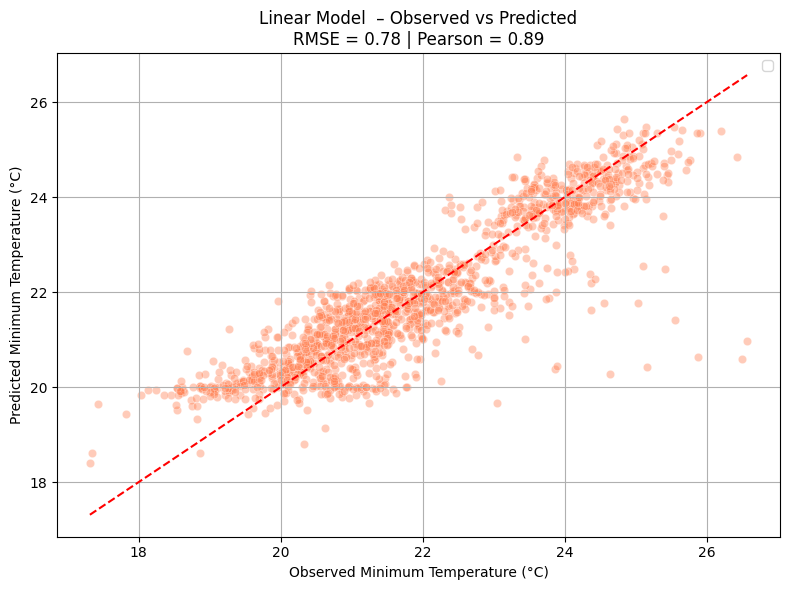

In [17]:
# Crear DataFrame para graficar
tmin_resul_linear = pd.DataFrame({
    'Tmin': y_true,
    'Tmim_pred': y_pred
})

# Graficar
plt.figure(figsize=(8,6))
sns.scatterplot(x='Tmin', y='Tmim_pred', data=tmin_resul_linear, alpha=0.4, color="#FF7F50")
plt.plot([tmin_resul_linear['Tmin'].min(), tmin_resul_linear['Tmin'].max()],
         [tmin_resul_linear['Tmin'].min(), tmin_resul_linear['Tmin'].max()],
         'r--', label='')

plt.xlabel("Observed Minimum Temperature (°C)")
plt.ylabel("Predicted Minimum Temperature (°C)")
plt.title(f"Linear Model  – Observed vs Predicted\nRMSE = {rmse:.2f} | Pearson = {pearson_corr:.2f}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Xgboost

In [18]:
df.columns

Index(['Estacion', 'year', 'week', 'Tmin', 'Latitud', 'Longitud', 'epi_week',
       'tmax_saga', 'tmin_saga', 'slope', 'aspect', 'tpi', 'cumbre', 'valle',
       'rugosity', 'dem', 'ndvi', 'sample_weight', 'week_sin', 'week_cos'],
      dtype='object')

In [40]:
# Variables predictoras
exclude = ['Tmin', 'Estacion', 'year', 'sample_weight','week', 'epi_week','dem', 'rugosity', 'tpi','slope','Latitud', 'Longitud','cumbre', 'week_cos']
features = [c for c in df.columns if c not in exclude]
print(features)
# Lista de estaciones
stations = df['Estacion'].unique()

['tmax_saga', 'tmin_saga', 'aspect', 'valle', 'ndvi', 'week_sin']


In [41]:
study = optuna.create_study(direction="minimize")
study.optimize(evaluate_model, n_trials=100)

[I 2025-07-09 13:51:18,359] A new study created in memory with name: no-name-d5958ac0-c6bc-4214-9831-1fcb299621e2
[I 2025-07-09 13:51:19,466] Trial 0 finished with value: 0.9284512878084906 and parameters: {'n_estimators': 185, 'max_depth': 3, 'learning_rate': 0.1429973349700001, 'subsample': 0.8066090610440806, 'colsample_bytree': 0.804141240100646, 'max_delta_step': 4, 'gamma': 19.792539763876913, 'min_child_weight': 12, 'reg_alpha': 0.08415028728537162, 'reg_lambda': 0.704170473032886}. Best is trial 0 with value: 0.9284512878084906.


RMSE Train: 0.729 | Pearson Train: 0.907
RMSE Test:  0.862 | Pearson Test:  0.872


[I 2025-07-09 13:51:22,791] Trial 1 finished with value: 0.9827631282670902 and parameters: {'n_estimators': 543, 'max_depth': 4, 'learning_rate': 0.19433614894660925, 'subsample': 0.6839434678072147, 'colsample_bytree': 0.9323432773202744, 'max_delta_step': 6, 'gamma': 10.921871757328603, 'min_child_weight': 11, 'reg_alpha': 0.6702221069755531, 'reg_lambda': 2.5963273980195285}. Best is trial 0 with value: 0.9284512878084906.


RMSE Train: 0.639 | Pearson Train: 0.930
RMSE Test:  0.868 | Pearson Test:  0.872


[I 2025-07-09 13:51:23,777] Trial 2 finished with value: 0.9122487528902659 and parameters: {'n_estimators': 153, 'max_depth': 4, 'learning_rate': 0.1136622958733202, 'subsample': 0.9281423641700839, 'colsample_bytree': 0.7563347228661707, 'max_delta_step': 6, 'gamma': 19.385755113031983, 'min_child_weight': 16, 'reg_alpha': 0.0066240520691585964, 'reg_lambda': 0.08311785976464203}. Best is trial 2 with value: 0.9122487528902659.


RMSE Train: 0.722 | Pearson Train: 0.909
RMSE Test:  0.849 | Pearson Test:  0.876


[I 2025-07-09 13:51:30,161] Trial 3 finished with value: 0.9754630464290387 and parameters: {'n_estimators': 762, 'max_depth': 7, 'learning_rate': 0.08909431046052946, 'subsample': 0.6342982602712949, 'colsample_bytree': 0.8095287300025191, 'max_delta_step': 3, 'gamma': 9.527598754571565, 'min_child_weight': 28, 'reg_alpha': 0.09395151008366438, 'reg_lambda': 1.6207498363054509}. Best is trial 2 with value: 0.9122487528902659.


RMSE Train: 0.619 | Pearson Train: 0.934
RMSE Test:  0.857 | Pearson Test:  0.875


[I 2025-07-09 13:51:36,202] Trial 4 finished with value: 0.9214774673971986 and parameters: {'n_estimators': 802, 'max_depth': 4, 'learning_rate': 0.09551664593172053, 'subsample': 0.9565304393813484, 'colsample_bytree': 0.9185056914866221, 'max_delta_step': 6, 'gamma': 17.044499321971138, 'min_child_weight': 38, 'reg_alpha': 0.10338784387446973, 'reg_lambda': 0.01540522906334935}. Best is trial 2 with value: 0.9122487528902659.


RMSE Train: 0.702 | Pearson Train: 0.914
RMSE Test:  0.848 | Pearson Test:  0.876


[I 2025-07-09 13:51:49,696] Trial 5 finished with value: 0.9735320083032991 and parameters: {'n_estimators': 952, 'max_depth': 10, 'learning_rate': 0.18162883596851181, 'subsample': 0.7778095364012334, 'colsample_bytree': 0.6285500266108276, 'max_delta_step': 6, 'gamma': 15.193565081946343, 'min_child_weight': 8, 'reg_alpha': 0.11773774387350124, 'reg_lambda': 0.03402810832601824}. Best is trial 2 with value: 0.9122487528902659.


RMSE Train: 0.614 | Pearson Train: 0.935
RMSE Test:  0.854 | Pearson Test:  0.875


[I 2025-07-09 13:51:51,634] Trial 6 finished with value: 0.9086884347694957 and parameters: {'n_estimators': 249, 'max_depth': 5, 'learning_rate': 0.04660977201576785, 'subsample': 0.9007395766866152, 'colsample_bytree': 0.9488803918815543, 'max_delta_step': 3, 'gamma': 15.683481428136442, 'min_child_weight': 5, 'reg_alpha': 0.054186574636350855, 'reg_lambda': 0.003128281213073326}. Best is trial 6 with value: 0.9086884347694957.


RMSE Train: 0.675 | Pearson Train: 0.920
RMSE Test:  0.831 | Pearson Test:  0.880


[I 2025-07-09 13:51:52,288] Trial 7 finished with value: 1.7191981453933196 and parameters: {'n_estimators': 73, 'max_depth': 10, 'learning_rate': 0.054915580289140294, 'subsample': 0.9077535753865842, 'colsample_bytree': 0.7128425363407891, 'max_delta_step': 6, 'gamma': 19.507358008739985, 'min_child_weight': 22, 'reg_alpha': 6.978750636316585, 'reg_lambda': 0.018146051993385898}. Best is trial 6 with value: 0.9086884347694957.


RMSE Train: 1.649 | Pearson Train: 0.903
RMSE Test:  1.696 | Pearson Test:  0.873


[I 2025-07-09 13:51:54,945] Trial 8 finished with value: 0.9319551610303382 and parameters: {'n_estimators': 367, 'max_depth': 4, 'learning_rate': 0.09411902384624062, 'subsample': 0.8350515606344077, 'colsample_bytree': 0.8449814468744987, 'max_delta_step': 3, 'gamma': 17.207741344547742, 'min_child_weight': 17, 'reg_alpha': 1.6039004321423367, 'reg_lambda': 1.0119739729648636}. Best is trial 6 with value: 0.9086884347694957.


RMSE Train: 0.694 | Pearson Train: 0.916
RMSE Test:  0.853 | Pearson Test:  0.875


[I 2025-07-09 13:51:56,102] Trial 9 finished with value: 0.9357855542240742 and parameters: {'n_estimators': 94, 'max_depth': 9, 'learning_rate': 0.16696222774637776, 'subsample': 0.807186585804824, 'colsample_bytree': 0.8440925399974653, 'max_delta_step': 6, 'gamma': 14.673411337446122, 'min_child_weight': 34, 'reg_alpha': 0.01870596523939071, 'reg_lambda': 0.06180033133826226}. Best is trial 6 with value: 0.9086884347694957.


RMSE Train: 0.670 | Pearson Train: 0.922
RMSE Test:  0.847 | Pearson Test:  0.877


[I 2025-07-09 13:51:59,590] Trial 10 finished with value: 0.9922951888533248 and parameters: {'n_estimators': 420, 'max_depth': 6, 'learning_rate': 0.017994863954868358, 'subsample': 0.9919267058438266, 'colsample_bytree': 0.9985745214381188, 'max_delta_step': 4, 'gamma': 2.554120165099908, 'min_child_weight': 6, 'reg_alpha': 0.0011157647233990381, 'reg_lambda': 0.0020308763990901685}. Best is trial 6 with value: 0.9086884347694957.


RMSE Train: 0.590 | Pearson Train: 0.945
RMSE Test:  0.858 | Pearson Test:  0.876


[I 2025-07-09 13:52:02,364] Trial 11 finished with value: 0.9501636234827906 and parameters: {'n_estimators': 280, 'max_depth': 6, 'learning_rate': 0.1300452855049813, 'subsample': 0.9056374931333894, 'colsample_bytree': 0.7089639723965385, 'max_delta_step': 5, 'gamma': 12.895175277277517, 'min_child_weight': 18, 'reg_alpha': 0.0051246876821012454, 'reg_lambda': 0.0014343331319234308}. Best is trial 6 with value: 0.9086884347694957.


RMSE Train: 0.640 | Pearson Train: 0.929
RMSE Test:  0.847 | Pearson Test:  0.878


[I 2025-07-09 13:52:06,682] Trial 12 finished with value: 0.9454202144715452 and parameters: {'n_estimators': 521, 'max_depth': 5, 'learning_rate': 0.04515460304234196, 'subsample': 0.8904072724205624, 'colsample_bytree': 0.7185417258855435, 'max_delta_step': 5, 'gamma': 8.699333792729071, 'min_child_weight': 5, 'reg_alpha': 0.011114278915941937, 'reg_lambda': 0.2189826647387937}. Best is trial 6 with value: 0.9086884347694957.


RMSE Train: 0.608 | Pearson Train: 0.936
RMSE Test:  0.833 | Pearson Test:  0.881


[I 2025-07-09 13:52:09,250] Trial 13 finished with value: 0.9336378834387009 and parameters: {'n_estimators': 245, 'max_depth': 7, 'learning_rate': 0.06424452328665066, 'subsample': 0.8671720785960989, 'colsample_bytree': 0.9038389526615563, 'max_delta_step': 4, 'gamma': 17.199321247131017, 'min_child_weight': 15, 'reg_alpha': 0.0012372659638948587, 'reg_lambda': 0.0056125688364179515}. Best is trial 6 with value: 0.9086884347694957.


RMSE Train: 0.664 | Pearson Train: 0.923
RMSE Test:  0.844 | Pearson Test:  0.877


[I 2025-07-09 13:52:11,472] Trial 14 finished with value: 0.949276003496352 and parameters: {'n_estimators': 357, 'max_depth': 3, 'learning_rate': 0.12544872823326644, 'subsample': 0.955699204026294, 'colsample_bytree': 0.7572380465721446, 'max_delta_step': 5, 'gamma': 6.3205547418007155, 'min_child_weight': 25, 'reg_alpha': 0.02597038704839287, 'reg_lambda': 0.19663724450554965}. Best is trial 6 with value: 0.9086884347694957.


RMSE Train: 0.661 | Pearson Train: 0.924
RMSE Test:  0.853 | Pearson Test:  0.876


[I 2025-07-09 13:52:12,246] Trial 15 finished with value: 12.604181466947452 and parameters: {'n_estimators': 181, 'max_depth': 5, 'learning_rate': 0.01640716642993721, 'subsample': 0.9992918420003749, 'colsample_bytree': 0.6289615753320135, 'max_delta_step': 3, 'gamma': 14.026828935338445, 'min_child_weight': 11, 'reg_alpha': 0.005504347160264972, 'reg_lambda': 0.006625966995888096}. Best is trial 6 with value: 0.9086884347694957.


RMSE Train: 12.599 | Pearson Train: nan
RMSE Test:  12.602 | Pearson Test:  nan


[I 2025-07-09 13:52:16,872] Trial 16 finished with value: 0.9237007754807394 and parameters: {'n_estimators': 566, 'max_depth': 5, 'learning_rate': 0.0724705825421064, 'subsample': 0.7310012386327303, 'colsample_bytree': 0.97503888343773, 'max_delta_step': 4, 'gamma': 18.746605426893233, 'min_child_weight': 21, 'reg_alpha': 0.5915935827074162, 'reg_lambda': 9.804697175128288}. Best is trial 6 with value: 0.9086884347694957.


RMSE Train: 0.700 | Pearson Train: 0.915
RMSE Test:  0.849 | Pearson Test:  0.876


[I 2025-07-09 13:52:19,983] Trial 17 finished with value: 0.9316281321940889 and parameters: {'n_estimators': 279, 'max_depth': 8, 'learning_rate': 0.040428706908413645, 'subsample': 0.9414100884374443, 'colsample_bytree': 0.8816345331097618, 'max_delta_step': 5, 'gamma': 12.494845937018118, 'min_child_weight': 29, 'reg_alpha': 0.00336160636124546, 'reg_lambda': 0.1202663074077094}. Best is trial 6 with value: 0.9086884347694957.


RMSE Train: 0.655 | Pearson Train: 0.925
RMSE Test:  0.839 | Pearson Test:  0.878


[I 2025-07-09 13:52:22,636] Trial 18 finished with value: 0.9342006857952259 and parameters: {'n_estimators': 447, 'max_depth': 3, 'learning_rate': 0.11651804227840608, 'subsample': 0.8490324537016953, 'colsample_bytree': 0.7485921130564088, 'max_delta_step': 3, 'gamma': 15.885457024834691, 'min_child_weight': 15, 'reg_alpha': 0.03160205663336507, 'reg_lambda': 0.0043898562216476}. Best is trial 6 with value: 0.9086884347694957.


RMSE Train: 0.707 | Pearson Train: 0.913
RMSE Test:  0.858 | Pearson Test:  0.873


[I 2025-07-09 13:52:28,634] Trial 19 finished with value: 0.9469045738364295 and parameters: {'n_estimators': 686, 'max_depth': 5, 'learning_rate': 0.15258943141430775, 'subsample': 0.9258485085797403, 'colsample_bytree': 0.6708776839842354, 'max_delta_step': 4, 'gamma': 17.280816023581554, 'min_child_weight': 9, 'reg_alpha': 0.2995994082409489, 'reg_lambda': 0.0010439646599010972}. Best is trial 6 with value: 0.9086884347694957.


RMSE Train: 0.655 | Pearson Train: 0.926
RMSE Test:  0.850 | Pearson Test:  0.876


[I 2025-07-09 13:52:30,093] Trial 20 finished with value: 0.9185241226176288 and parameters: {'n_estimators': 156, 'max_depth': 6, 'learning_rate': 0.07921366178266812, 'subsample': 0.7591986952997132, 'colsample_bytree': 0.7703225862650898, 'max_delta_step': 5, 'gamma': 18.342612654457263, 'min_child_weight': 18, 'reg_alpha': 0.043791226185456326, 'reg_lambda': 0.3362038216009683}. Best is trial 6 with value: 0.9086884347694957.


RMSE Train: 0.690 | Pearson Train: 0.917
RMSE Test:  0.842 | Pearson Test:  0.878


[I 2025-07-09 13:52:31,510] Trial 21 finished with value: 0.9172701348323636 and parameters: {'n_estimators': 161, 'max_depth': 6, 'learning_rate': 0.08122513201297551, 'subsample': 0.7487166601506262, 'colsample_bytree': 0.7620688888096177, 'max_delta_step': 5, 'gamma': 18.55833468397556, 'min_child_weight': 19, 'reg_alpha': 0.03907013384167184, 'reg_lambda': 0.3482695986424018}. Best is trial 6 with value: 0.9086884347694957.


RMSE Train: 0.693 | Pearson Train: 0.916
RMSE Test:  0.842 | Pearson Test:  0.878


[I 2025-07-09 13:52:33,515] Trial 22 finished with value: 0.9320484506839132 and parameters: {'n_estimators': 267, 'max_depth': 4, 'learning_rate': 0.11168947613792736, 'subsample': 0.7292111442158021, 'colsample_bytree': 0.8470645012546999, 'max_delta_step': 5, 'gamma': 19.63715747892726, 'min_child_weight': 26, 'reg_alpha': 0.01057554603086366, 'reg_lambda': 0.044502021172675016}. Best is trial 6 with value: 0.9086884347694957.


RMSE Train: 0.708 | Pearson Train: 0.913
RMSE Test:  0.857 | Pearson Test:  0.874


[I 2025-07-09 13:52:34,651] Trial 23 finished with value: 0.98098589558353 and parameters: {'n_estimators': 143, 'max_depth': 7, 'learning_rate': 0.03601431292201303, 'subsample': 0.6878030772824194, 'colsample_bytree': 0.6786648898386407, 'max_delta_step': 6, 'gamma': 16.06234490227776, 'min_child_weight': 21, 'reg_alpha': 0.0027573077167994766, 'reg_lambda': 0.39612947315054525}. Best is trial 6 with value: 0.9086884347694957.


RMSE Train: 0.846 | Pearson Train: 0.908
RMSE Test:  0.936 | Pearson Test:  0.880


[I 2025-07-09 13:52:37,630] Trial 24 finished with value: 0.934259356418963 and parameters: {'n_estimators': 328, 'max_depth': 6, 'learning_rate': 0.07689586131276922, 'subsample': 0.8341516897346374, 'colsample_bytree': 0.77758240273662, 'max_delta_step': 5, 'gamma': 14.14458687559621, 'min_child_weight': 31, 'reg_alpha': 0.011321695727357079, 'reg_lambda': 4.610216592679022}. Best is trial 6 with value: 0.9086884347694957.


RMSE Train: 0.681 | Pearson Train: 0.920
RMSE Test:  0.850 | Pearson Test:  0.876


[I 2025-07-09 13:52:40,176] Trial 25 finished with value: 0.9287035193153449 and parameters: {'n_estimators': 225, 'max_depth': 8, 'learning_rate': 0.05778874154117779, 'subsample': 0.8761041294739218, 'colsample_bytree': 0.9551720255782219, 'max_delta_step': 4, 'gamma': 18.311011973495027, 'min_child_weight': 14, 'reg_alpha': 0.20247978448291756, 'reg_lambda': 0.08263747864480613}. Best is trial 6 with value: 0.9086884347694957.


RMSE Train: 0.664 | Pearson Train: 0.923
RMSE Test:  0.840 | Pearson Test:  0.878


[I 2025-07-09 13:52:40,839] Trial 26 finished with value: 0.9050694736119954 and parameters: {'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.10292532773002301, 'subsample': 0.7583977899303185, 'colsample_bytree': 0.8191058085230747, 'max_delta_step': 6, 'gamma': 12.506244933856706, 'min_child_weight': 24, 'reg_alpha': 0.03798392216039995, 'reg_lambda': 0.6318896262018575}. Best is trial 26 with value: 0.9050694736119954.


RMSE Train: 0.705 | Pearson Train: 0.913
RMSE Test:  0.838 | Pearson Test:  0.879


[I 2025-07-09 13:52:41,463] Trial 27 finished with value: 0.9133063099427845 and parameters: {'n_estimators': 70, 'max_depth': 5, 'learning_rate': 0.10425628605649451, 'subsample': 0.6098876546992672, 'colsample_bytree': 0.879548252262763, 'max_delta_step': 6, 'gamma': 12.441643313130376, 'min_child_weight': 25, 'reg_alpha': 0.017731619479487464, 'reg_lambda': 0.020137922838605965}. Best is trial 26 with value: 0.9050694736119954.


RMSE Train: 0.711 | Pearson Train: 0.912
RMSE Test:  0.846 | Pearson Test:  0.877


[I 2025-07-09 13:52:42,409] Trial 28 finished with value: 0.9380252623853287 and parameters: {'n_estimators': 123, 'max_depth': 4, 'learning_rate': 0.14238976243234175, 'subsample': 0.700101453080266, 'colsample_bytree': 0.8178723673172142, 'max_delta_step': 6, 'gamma': 10.415653727827994, 'min_child_weight': 35, 'reg_alpha': 0.06651545015841782, 'reg_lambda': 0.0026513903966529943}. Best is trial 26 with value: 0.9050694736119954.


RMSE Train: 0.691 | Pearson Train: 0.918
RMSE Test:  0.856 | Pearson Test:  0.875


[I 2025-07-09 13:52:43,709] Trial 29 finished with value: 0.9730370880855514 and parameters: {'n_estimators': 208, 'max_depth': 3, 'learning_rate': 0.14152685809556512, 'subsample': 0.7966254388736227, 'colsample_bytree': 0.7987008543121411, 'max_delta_step': 3, 'gamma': 6.202773299332044, 'min_child_weight': 8, 'reg_alpha': 0.18470602799429292, 'reg_lambda': 0.9859953859152485}. Best is trial 26 with value: 0.9050694736119954.


RMSE Train: 0.637 | Pearson Train: 0.930
RMSE Test:  0.861 | Pearson Test:  0.873


[I 2025-07-09 13:52:47,352] Trial 30 finished with value: 0.9646493141245538 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.1656216237405646, 'subsample': 0.9681433321010467, 'colsample_bytree': 0.6014209120396459, 'max_delta_step': 6, 'gamma': 13.316136316274033, 'min_child_weight': 12, 'reg_alpha': 0.0613979183787323, 'reg_lambda': 0.009353323770902257}. Best is trial 26 with value: 0.9050694736119954.


RMSE Train: 0.655 | Pearson Train: 0.926
RMSE Test:  0.861 | Pearson Test:  0.872


[I 2025-07-09 13:52:48,089] Trial 31 finished with value: 0.9265081182137727 and parameters: {'n_estimators': 85, 'max_depth': 5, 'learning_rate': 0.10293385522204408, 'subsample': 0.6081794811405522, 'colsample_bytree': 0.8818796889137964, 'max_delta_step': 6, 'gamma': 11.93818577236447, 'min_child_weight': 25, 'reg_alpha': 0.017306121330510512, 'reg_lambda': 0.02697075916464877}. Best is trial 26 with value: 0.9050694736119954.


RMSE Train: 0.698 | Pearson Train: 0.915
RMSE Test:  0.850 | Pearson Test:  0.876


[I 2025-07-09 13:52:48,739] Trial 32 finished with value: 0.8896240362331187 and parameters: {'n_estimators': 72, 'max_depth': 4, 'learning_rate': 0.12388021507119797, 'subsample': 0.652057864538497, 'colsample_bytree': 0.8715166646794916, 'max_delta_step': 6, 'gamma': 11.6897115911541, 'min_child_weight': 24, 'reg_alpha': 0.00855364148186736, 'reg_lambda': 0.13198380090240402}. Best is trial 32 with value: 0.8896240362331187.


RMSE Train: 0.716 | Pearson Train: 0.911
RMSE Test:  0.832 | Pearson Test:  0.881


[I 2025-07-09 13:52:50,260] Trial 33 finished with value: 0.9402009901938024 and parameters: {'n_estimators': 202, 'max_depth': 4, 'learning_rate': 0.12602823307233943, 'subsample': 0.6703656013133567, 'colsample_bytree': 0.9366207273817055, 'max_delta_step': 6, 'gamma': 11.25904641560795, 'min_child_weight': 28, 'reg_alpha': 0.0073035049937945126, 'reg_lambda': 2.4216753065268626}. Best is trial 32 with value: 0.8896240362331187.


RMSE Train: 0.678 | Pearson Train: 0.921
RMSE Test:  0.853 | Pearson Test:  0.876


[I 2025-07-09 13:52:51,296] Trial 34 finished with value: 0.9423707673509703 and parameters: {'n_estimators': 143, 'max_depth': 4, 'learning_rate': 0.11718937793325486, 'subsample': 0.6490358577662952, 'colsample_bytree': 0.8318114525182292, 'max_delta_step': 6, 'gamma': 8.373990897250328, 'min_child_weight': 31, 'reg_alpha': 0.0032949917909340758, 'reg_lambda': 0.6358983557675266}. Best is trial 32 with value: 0.8896240362331187.


RMSE Train: 0.680 | Pearson Train: 0.920
RMSE Test:  0.855 | Pearson Test:  0.876


[I 2025-07-09 13:52:53,150] Trial 35 finished with value: 0.9466767328032006 and parameters: {'n_estimators': 309, 'max_depth': 3, 'learning_rate': 0.15700937865312303, 'subsample': 0.7150847624301007, 'colsample_bytree': 0.7963862270718491, 'max_delta_step': 6, 'gamma': 10.160472615012704, 'min_child_weight': 20, 'reg_alpha': 0.0021846192810114026, 'reg_lambda': 0.1724987040481273}. Best is trial 32 with value: 0.8896240362331187.


RMSE Train: 0.667 | Pearson Train: 0.923
RMSE Test:  0.853 | Pearson Test:  0.876


[I 2025-07-09 13:52:54,153] Trial 36 finished with value: 0.9474601532115474 and parameters: {'n_estimators': 123, 'max_depth': 4, 'learning_rate': 0.19390827179856632, 'subsample': 0.8058501420740145, 'colsample_bytree': 0.9019248492603495, 'max_delta_step': 6, 'gamma': 15.723191989161284, 'min_child_weight': 24, 'reg_alpha': 0.09939870978631303, 'reg_lambda': 0.5515202758611123}. Best is trial 32 with value: 0.8896240362331187.


RMSE Train: 0.697 | Pearson Train: 0.916
RMSE Test:  0.864 | Pearson Test:  0.871


[I 2025-07-09 13:52:55,541] Trial 37 finished with value: 0.9266007184326512 and parameters: {'n_estimators': 222, 'max_depth': 3, 'learning_rate': 0.09483415142170035, 'subsample': 0.6573960868185622, 'colsample_bytree': 0.866770911995035, 'max_delta_step': 6, 'gamma': 11.449538508334339, 'min_child_weight': 23, 'reg_alpha': 0.008084639773116058, 'reg_lambda': 1.6431164668801965}. Best is trial 32 with value: 0.8896240362331187.


RMSE Train: 0.701 | Pearson Train: 0.915
RMSE Test:  0.852 | Pearson Test:  0.876


[I 2025-07-09 13:53:02,664] Trial 38 finished with value: 0.9360701397296813 and parameters: {'n_estimators': 876, 'max_depth': 5, 'learning_rate': 0.029030460420611665, 'subsample': 0.9222284053084886, 'colsample_bytree': 0.9322956359163479, 'max_delta_step': 3, 'gamma': 9.02472320824127, 'min_child_weight': 40, 'reg_alpha': 0.024919272578614506, 'reg_lambda': 0.0995417268069126}. Best is trial 32 with value: 0.8896240362331187.


RMSE Train: 0.649 | Pearson Train: 0.927
RMSE Test:  0.841 | Pearson Test:  0.878


[I 2025-07-09 13:53:03,295] Trial 39 finished with value: 0.8995798209084349 and parameters: {'n_estimators': 74, 'max_depth': 4, 'learning_rate': 0.12788778957232708, 'subsample': 0.6287475571494286, 'colsample_bytree': 0.9619644942568288, 'max_delta_step': 5, 'gamma': 13.578246274907777, 'min_child_weight': 27, 'reg_alpha': 0.047892335544604134, 'reg_lambda': 0.04628008394070637}. Best is trial 32 with value: 0.8896240362331187.


RMSE Train: 0.729 | Pearson Train: 0.907
RMSE Test:  0.843 | Pearson Test:  0.878


[I 2025-07-09 13:53:07,740] Trial 40 finished with value: 0.9644686551113062 and parameters: {'n_estimators': 633, 'max_depth': 4, 'learning_rate': 0.1288458315465779, 'subsample': 0.6307284506231868, 'colsample_bytree': 0.9624260081970764, 'max_delta_step': 5, 'gamma': 13.539093173940419, 'min_child_weight': 27, 'reg_alpha': 0.39250275400622653, 'reg_lambda': 0.011219775203831784}. Best is trial 32 with value: 0.8896240362331187.


RMSE Train: 0.666 | Pearson Train: 0.924
RMSE Test:  0.865 | Pearson Test:  0.873


[I 2025-07-09 13:53:08,291] Trial 41 finished with value: 0.8846203082303568 and parameters: {'n_estimators': 73, 'max_depth': 3, 'learning_rate': 0.13776499421340654, 'subsample': 0.6237504647548858, 'colsample_bytree': 0.9926934094488432, 'max_delta_step': 6, 'gamma': 15.318908645854147, 'min_child_weight': 30, 'reg_alpha': 0.056445838255342974, 'reg_lambda': 0.04799106767404879}. Best is trial 41 with value: 0.8846203082303568.


RMSE Train: 0.753 | Pearson Train: 0.901
RMSE Test:  0.841 | Pearson Test:  0.879


[I 2025-07-09 13:53:08,860] Trial 42 finished with value: 0.8826899968170077 and parameters: {'n_estimators': 71, 'max_depth': 3, 'learning_rate': 0.15087937404868365, 'subsample': 0.6327767074347492, 'colsample_bytree': 0.9875300526809574, 'max_delta_step': 6, 'gamma': 14.948656145287078, 'min_child_weight': 30, 'reg_alpha': 0.14206413548322644, 'reg_lambda': 0.04985439320777196}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.746 | Pearson Train: 0.903
RMSE Test:  0.837 | Pearson Test:  0.879


[I 2025-07-09 13:53:09,613] Trial 43 finished with value: 0.8962140062817247 and parameters: {'n_estimators': 106, 'max_depth': 3, 'learning_rate': 0.15123331390021674, 'subsample': 0.6328622176462296, 'colsample_bytree': 0.9949387503246896, 'max_delta_step': 6, 'gamma': 14.862529868191332, 'min_child_weight': 30, 'reg_alpha': 1.5502793960944286, 'reg_lambda': 0.05228371414266479}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.736 | Pearson Train: 0.906
RMSE Test:  0.843 | Pearson Test:  0.878


[I 2025-07-09 13:53:10,431] Trial 44 finished with value: 0.9168093839753177 and parameters: {'n_estimators': 120, 'max_depth': 3, 'learning_rate': 0.1772986966261708, 'subsample': 0.6279617856731508, 'colsample_bytree': 0.996841688471369, 'max_delta_step': 6, 'gamma': 14.512800907854512, 'min_child_weight': 33, 'reg_alpha': 3.1875045860639553, 'reg_lambda': 0.04396152775734444}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.729 | Pearson Train: 0.908
RMSE Test:  0.854 | Pearson Test:  0.874


[I 2025-07-09 13:53:11,584] Trial 45 finished with value: 0.9291230548662539 and parameters: {'n_estimators': 177, 'max_depth': 3, 'learning_rate': 0.15273796285348934, 'subsample': 0.6018905583887194, 'colsample_bytree': 0.9809727008018614, 'max_delta_step': 6, 'gamma': 16.122338204977368, 'min_child_weight': 30, 'reg_alpha': 9.911360923269806, 'reg_lambda': 0.061989566529121666}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.734 | Pearson Train: 0.906
RMSE Test:  0.864 | Pearson Test:  0.875


[I 2025-07-09 13:53:12,417] Trial 46 finished with value: 0.9212692027816904 and parameters: {'n_estimators': 122, 'max_depth': 3, 'learning_rate': 0.13958480837537857, 'subsample': 0.6494222805645572, 'colsample_bytree': 0.9870420528039102, 'max_delta_step': 6, 'gamma': 14.559718511544386, 'min_child_weight': 37, 'reg_alpha': 1.218319728955046, 'reg_lambda': 0.02981495315524555}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.734 | Pearson Train: 0.906
RMSE Test:  0.859 | Pearson Test:  0.875


[I 2025-07-09 13:53:19,325] Trial 47 finished with value: 0.957918368293506 and parameters: {'n_estimators': 988, 'max_depth': 4, 'learning_rate': 0.16417475436664017, 'subsample': 0.6699249378715788, 'colsample_bytree': 0.9594594094399926, 'max_delta_step': 5, 'gamma': 13.702780425943315, 'min_child_weight': 33, 'reg_alpha': 0.1488288915527483, 'reg_lambda': 0.15249200434760796}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.658 | Pearson Train: 0.925
RMSE Test:  0.858 | Pearson Test:  0.875


[I 2025-07-09 13:53:20,056] Trial 48 finished with value: 0.9053701076005443 and parameters: {'n_estimators': 102, 'max_depth': 3, 'learning_rate': 0.1335086255315418, 'subsample': 0.6213374024997675, 'colsample_bytree': 0.9244085799682785, 'max_delta_step': 6, 'gamma': 15.318041322679065, 'min_child_weight': 28, 'reg_alpha': 2.918043894842586, 'reg_lambda': 0.07241910137388749}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.740 | Pearson Train: 0.904
RMSE Test:  0.850 | Pearson Test:  0.876


[I 2025-07-09 13:53:21,561] Trial 49 finished with value: 0.9439681757276712 and parameters: {'n_estimators': 192, 'max_depth': 4, 'learning_rate': 0.14701184093241818, 'subsample': 0.6424608948842718, 'colsample_bytree': 0.9127775314123076, 'max_delta_step': 6, 'gamma': 16.569831815258226, 'min_child_weight': 32, 'reg_alpha': 0.9517816224021277, 'reg_lambda': 0.04247947971412544}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.706 | Pearson Train: 0.914
RMSE Test:  0.865 | Pearson Test:  0.872


[I 2025-07-09 13:53:22,116] Trial 50 finished with value: 0.8921642307036016 and parameters: {'n_estimators': 71, 'max_depth': 3, 'learning_rate': 0.1744301480513349, 'subsample': 0.6684120435754878, 'colsample_bytree': 0.9772157211161401, 'max_delta_step': 5, 'gamma': 14.718502034486832, 'min_child_weight': 29, 'reg_alpha': 0.34237692685167637, 'reg_lambda': 0.019130403996852736}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.745 | Pearson Train: 0.903
RMSE Test:  0.843 | Pearson Test:  0.879


[I 2025-07-09 13:53:22,664] Trial 51 finished with value: 0.8983167615283107 and parameters: {'n_estimators': 70, 'max_depth': 3, 'learning_rate': 0.18207912519976657, 'subsample': 0.6673587243472181, 'colsample_bytree': 0.9447104543014078, 'max_delta_step': 5, 'gamma': 15.039522012821621, 'min_child_weight': 29, 'reg_alpha': 0.39440643732767416, 'reg_lambda': 0.019893946400841567}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.745 | Pearson Train: 0.903
RMSE Test:  0.847 | Pearson Test:  0.878


[I 2025-07-09 13:53:23,399] Trial 52 finished with value: 0.9162167884190988 and parameters: {'n_estimators': 106, 'max_depth': 3, 'learning_rate': 0.1807926010097726, 'subsample': 0.6734120534749276, 'colsample_bytree': 0.9766962067270275, 'max_delta_step': 5, 'gamma': 16.812191003136427, 'min_child_weight': 35, 'reg_alpha': 0.5489704165123558, 'reg_lambda': 0.01458088726667825}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.742 | Pearson Train: 0.904
RMSE Test:  0.858 | Pearson Test:  0.874


[I 2025-07-09 13:53:24,402] Trial 53 finished with value: 0.9290162675004965 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.19821774732624367, 'subsample': 0.6838139986162024, 'colsample_bytree': 0.9410495233100612, 'max_delta_step': 5, 'gamma': 14.836065691143322, 'min_child_weight': 30, 'reg_alpha': 0.35579802873883737, 'reg_lambda': 0.02156661463766658}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.717 | Pearson Train: 0.911
RMSE Test:  0.858 | Pearson Test:  0.874


[I 2025-07-09 13:53:25,187] Trial 54 finished with value: 0.9013165961099551 and parameters: {'n_estimators': 107, 'max_depth': 3, 'learning_rate': 0.17652672943954573, 'subsample': 0.7012492246279931, 'colsample_bytree': 0.9999593112105907, 'max_delta_step': 6, 'gamma': 17.77811091005286, 'min_child_weight': 29, 'reg_alpha': 2.1561884398661326, 'reg_lambda': 0.01277626446933007}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.740 | Pearson Train: 0.905
RMSE Test:  0.847 | Pearson Test:  0.876


[I 2025-07-09 13:53:26,333] Trial 55 finished with value: 0.9420770578201694 and parameters: {'n_estimators': 174, 'max_depth': 3, 'learning_rate': 0.19141907859305135, 'subsample': 0.6539607597186877, 'colsample_bytree': 0.9714962605915018, 'max_delta_step': 5, 'gamma': 15.342189758571552, 'min_child_weight': 32, 'reg_alpha': 0.8454558724670039, 'reg_lambda': 0.008534140695633777}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.722 | Pearson Train: 0.910
RMSE Test:  0.869 | Pearson Test:  0.873


[I 2025-07-09 13:53:28,034] Trial 56 finished with value: 0.9503036442056377 and parameters: {'n_estimators': 246, 'max_depth': 3, 'learning_rate': 0.15916088134057008, 'subsample': 0.6156311635961944, 'colsample_bytree': 0.9837963548821357, 'max_delta_step': 6, 'gamma': 12.886581458854124, 'min_child_weight': 36, 'reg_alpha': 0.2512676395579788, 'reg_lambda': 0.11716435447248322}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.705 | Pearson Train: 0.914
RMSE Test:  0.869 | Pearson Test:  0.871


[I 2025-07-09 13:53:28,986] Trial 57 finished with value: 0.9363649008011673 and parameters: {'n_estimators': 144, 'max_depth': 3, 'learning_rate': 0.1715883191587525, 'subsample': 0.6372096485023243, 'colsample_bytree': 0.9023417797104075, 'max_delta_step': 5, 'gamma': 16.301341419274358, 'min_child_weight': 27, 'reg_alpha': 0.4495977592036817, 'reg_lambda': 0.027470986559651276}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.729 | Pearson Train: 0.908
RMSE Test:  0.867 | Pearson Test:  0.872


[I 2025-07-09 13:53:34,661] Trial 58 finished with value: 1.1067767665858534 and parameters: {'n_estimators': 808, 'max_depth': 4, 'learning_rate': 0.1873034815590726, 'subsample': 0.663675954262144, 'colsample_bytree': 0.920349875668306, 'max_delta_step': 4, 'gamma': 2.471017724010327, 'min_child_weight': 29, 'reg_alpha': 0.12625122748726733, 'reg_lambda': 0.22581244492858987}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.460 | Pearson Train: 0.964
RMSE Test:  0.891 | Pearson Test:  0.865


[I 2025-07-09 13:53:35,231] Trial 59 finished with value: 0.8923196566938475 and parameters: {'n_estimators': 75, 'max_depth': 3, 'learning_rate': 0.13686062924065542, 'subsample': 0.6905268108087785, 'colsample_bytree': 0.9496116753986803, 'max_delta_step': 6, 'gamma': 14.846542516289976, 'min_child_weight': 31, 'reg_alpha': 1.4729778194678238, 'reg_lambda': 0.05937083123406628}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.751 | Pearson Train: 0.901
RMSE Test:  0.845 | Pearson Test:  0.878


[I 2025-07-09 13:53:38,122] Trial 60 finished with value: 0.9552162178336138 and parameters: {'n_estimators': 390, 'max_depth': 4, 'learning_rate': 0.14822858393611762, 'subsample': 0.687797447297249, 'colsample_bytree': 0.9489304729594774, 'max_delta_step': 6, 'gamma': 17.708666194928767, 'min_child_weight': 34, 'reg_alpha': 1.653428074914943, 'reg_lambda': 0.05778873120920122}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.702 | Pearson Train: 0.915
RMSE Test:  0.871 | Pearson Test:  0.871


[I 2025-07-09 13:53:38,725] Trial 61 finished with value: 0.893573965760653 and parameters: {'n_estimators': 74, 'max_depth': 3, 'learning_rate': 0.13692158884745978, 'subsample': 0.707310188608957, 'colsample_bytree': 0.9677195411127807, 'max_delta_step': 6, 'gamma': 14.983212183715223, 'min_child_weight': 31, 'reg_alpha': 5.091475816023249, 'reg_lambda': 0.03318682144845881}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.753 | Pearson Train: 0.901
RMSE Test:  0.847 | Pearson Test:  0.877


[I 2025-07-09 13:53:39,476] Trial 62 finished with value: 0.9005965872099521 and parameters: {'n_estimators': 106, 'max_depth': 3, 'learning_rate': 0.13618723137203537, 'subsample': 0.7065803428199218, 'colsample_bytree': 0.9694595234527091, 'max_delta_step': 6, 'gamma': 14.19509563815138, 'min_child_weight': 31, 'reg_alpha': 5.533103064520569, 'reg_lambda': 0.08618386735976537}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.740 | Pearson Train: 0.905
RMSE Test:  0.847 | Pearson Test:  0.876


[I 2025-07-09 13:53:40,633] Trial 63 finished with value: 0.925381322162369 and parameters: {'n_estimators': 176, 'max_depth': 3, 'learning_rate': 0.11979797873287955, 'subsample': 0.7357509839250909, 'colsample_bytree': 0.9977564232789443, 'max_delta_step': 6, 'gamma': 7.643965076868346, 'min_child_weight': 33, 'reg_alpha': 2.5681190903971554, 'reg_lambda': 0.03484835817681917}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.686 | Pearson Train: 0.919
RMSE Test:  0.846 | Pearson Test:  0.879


[I 2025-07-09 13:53:41,586] Trial 64 finished with value: 0.9291520076758661 and parameters: {'n_estimators': 137, 'max_depth': 3, 'learning_rate': 0.15017334904833843, 'subsample': 0.682874871891511, 'colsample_bytree': 0.9872219365373518, 'max_delta_step': 6, 'gamma': 15.438437556239792, 'min_child_weight': 30, 'reg_alpha': 1.6984615503355338, 'reg_lambda': 0.058796520655739405}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.727 | Pearson Train: 0.908
RMSE Test:  0.862 | Pearson Test:  0.873


[I 2025-07-09 13:53:42,384] Trial 65 finished with value: 0.9145222765016574 and parameters: {'n_estimators': 95, 'max_depth': 4, 'learning_rate': 0.13492476167219122, 'subsample': 0.7179971312343506, 'colsample_bytree': 0.9504769401135209, 'max_delta_step': 6, 'gamma': 12.972733344372674, 'min_child_weight': 26, 'reg_alpha': 3.6926379850688322, 'reg_lambda': 0.038007954124058246}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.707 | Pearson Train: 0.913
RMSE Test:  0.845 | Pearson Test:  0.878


[I 2025-07-09 13:53:43,838] Trial 66 finished with value: 0.9396918944911854 and parameters: {'n_estimators': 223, 'max_depth': 3, 'learning_rate': 0.10941962851965147, 'subsample': 0.6408815520006717, 'colsample_bytree': 0.9690224814571474, 'max_delta_step': 6, 'gamma': 3.724236486642596, 'min_child_weight': 32, 'reg_alpha': 6.3308082235929515, 'reg_lambda': 0.12233620401090668}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.660 | Pearson Train: 0.925
RMSE Test:  0.847 | Pearson Test:  0.879


[I 2025-07-09 13:53:44,690] Trial 67 finished with value: 0.9215788566128227 and parameters: {'n_estimators': 74, 'max_depth': 8, 'learning_rate': 0.12105870419425016, 'subsample': 0.6172350505082472, 'colsample_bytree': 0.9304549943491416, 'max_delta_step': 6, 'gamma': 14.21900057574409, 'min_child_weight': 22, 'reg_alpha': 3.998416846110172, 'reg_lambda': 0.016760762502855096}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.682 | Pearson Train: 0.919
RMSE Test:  0.842 | Pearson Test:  0.878


[I 2025-07-09 13:53:46,545] Trial 68 finished with value: 0.9836394260650989 and parameters: {'n_estimators': 162, 'max_depth': 9, 'learning_rate': 0.15860253019915121, 'subsample': 0.6020419878168499, 'colsample_bytree': 0.9842483012010408, 'max_delta_step': 6, 'gamma': 11.79604030251043, 'min_child_weight': 34, 'reg_alpha': 0.08318766708944428, 'reg_lambda': 0.2502115070818314}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.660 | Pearson Train: 0.925
RMSE Test:  0.876 | Pearson Test:  0.870


[I 2025-07-09 13:53:47,431] Trial 69 finished with value: 0.9173801857955989 and parameters: {'n_estimators': 125, 'max_depth': 3, 'learning_rate': 0.14262384746889206, 'subsample': 0.7856603702614716, 'colsample_bytree': 0.9556762335141448, 'max_delta_step': 6, 'gamma': 16.914277903555522, 'min_child_weight': 26, 'reg_alpha': 1.0824524531603688, 'reg_lambda': 0.07238152108889745}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.735 | Pearson Train: 0.906
RMSE Test:  0.857 | Pearson Test:  0.874


[I 2025-07-09 13:53:51,191] Trial 70 finished with value: 0.9520832427027721 and parameters: {'n_estimators': 502, 'max_depth': 4, 'learning_rate': 0.16903460029029185, 'subsample': 0.6963923993889001, 'colsample_bytree': 0.9128509115476439, 'max_delta_step': 6, 'gamma': 14.828624846516314, 'min_child_weight': 28, 'reg_alpha': 8.730120341023127, 'reg_lambda': 0.024140948792993673}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.682 | Pearson Train: 0.920
RMSE Test:  0.862 | Pearson Test:  0.873


[I 2025-07-09 13:53:51,742] Trial 71 finished with value: 0.902808531568078 and parameters: {'n_estimators': 72, 'max_depth': 3, 'learning_rate': 0.1864141308764783, 'subsample': 0.6599084275777863, 'colsample_bytree': 0.937587145514122, 'max_delta_step': 5, 'gamma': 14.94301926762505, 'min_child_weight': 30, 'reg_alpha': 0.719223211708953, 'reg_lambda': 0.01970940633514664}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.746 | Pearson Train: 0.903
RMSE Test:  0.851 | Pearson Test:  0.877


[I 2025-07-09 13:53:52,294] Trial 72 finished with value: 0.9005282705117933 and parameters: {'n_estimators': 70, 'max_depth': 3, 'learning_rate': 0.160749363214005, 'subsample': 0.6763087053192071, 'colsample_bytree': 0.9462886673643481, 'max_delta_step': 6, 'gamma': 15.908603086846805, 'min_child_weight': 29, 'reg_alpha': 0.29343052281413246, 'reg_lambda': 0.030098274794443988}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.748 | Pearson Train: 0.902
RMSE Test:  0.850 | Pearson Test:  0.877


[I 2025-07-09 13:53:52,964] Trial 73 finished with value: 0.9137001794018693 and parameters: {'n_estimators': 98, 'max_depth': 3, 'learning_rate': 0.17155168231578324, 'subsample': 0.645794354356009, 'colsample_bytree': 0.971796212920432, 'max_delta_step': 4, 'gamma': 15.501523842253134, 'min_child_weight': 31, 'reg_alpha': 0.20587929215189354, 'reg_lambda': 0.004851330008618979}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.741 | Pearson Train: 0.904
RMSE Test:  0.856 | Pearson Test:  0.875


[I 2025-07-09 13:53:54,308] Trial 74 finished with value: 0.9509170052445257 and parameters: {'n_estimators': 195, 'max_depth': 3, 'learning_rate': 0.1534522028700664, 'subsample': 0.6628705422927655, 'colsample_bytree': 0.9888464544935163, 'max_delta_step': 6, 'gamma': 10.639799073695908, 'min_child_weight': 28, 'reg_alpha': 0.5803779118916556, 'reg_lambda': 0.04931708764741457}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.692 | Pearson Train: 0.917
RMSE Test:  0.865 | Pearson Test:  0.873


[I 2025-07-09 13:53:55,402] Trial 75 finished with value: 0.9211980124155121 and parameters: {'n_estimators': 139, 'max_depth': 4, 'learning_rate': 0.12223400628279468, 'subsample': 0.6237328678845284, 'colsample_bytree': 0.8953161306073952, 'max_delta_step': 6, 'gamma': 13.812913856838218, 'min_child_weight': 24, 'reg_alpha': 4.487546960630469, 'reg_lambda': 0.13738557308162389}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.701 | Pearson Train: 0.915
RMSE Test:  0.848 | Pearson Test:  0.876


[I 2025-07-09 13:53:56,138] Trial 76 finished with value: 0.8906791711718668 and parameters: {'n_estimators': 101, 'max_depth': 3, 'learning_rate': 0.14567808611558258, 'subsample': 0.6359125385935213, 'colsample_bytree': 0.8649921399085355, 'max_delta_step': 5, 'gamma': 18.974101083358608, 'min_child_weight': 32, 'reg_alpha': 2.1244606475231578, 'reg_lambda': 0.03481589638247279}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.753 | Pearson Train: 0.901
RMSE Test:  0.845 | Pearson Test:  0.877


[I 2025-07-09 13:53:56,968] Trial 77 finished with value: 0.9097005622079403 and parameters: {'n_estimators': 99, 'max_depth': 4, 'learning_rate': 0.1447669644106697, 'subsample': 0.6352817820706017, 'colsample_bytree': 0.8615051204205127, 'max_delta_step': 6, 'gamma': 19.72070334523944, 'min_child_weight': 36, 'reg_alpha': 1.9159963069447603, 'reg_lambda': 0.09546112015191822}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.740 | Pearson Train: 0.905
RMSE Test:  0.853 | Pearson Test:  0.875


[I 2025-07-09 13:53:58,001] Trial 78 finished with value: 0.9049348305794223 and parameters: {'n_estimators': 161, 'max_depth': 3, 'learning_rate': 0.13697002130384897, 'subsample': 0.6133263971406304, 'colsample_bytree': 0.8634166583868798, 'max_delta_step': 6, 'gamma': 18.93007227490434, 'min_child_weight': 33, 'reg_alpha': 1.1626499763432987, 'reg_lambda': 0.03539077363910877}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.744 | Pearson Train: 0.904
RMSE Test:  0.851 | Pearson Test:  0.876


[I 2025-07-09 13:54:00,199] Trial 79 finished with value: 0.9344172190875041 and parameters: {'n_estimators': 281, 'max_depth': 4, 'learning_rate': 0.13111980188235547, 'subsample': 0.7136729548364584, 'colsample_bytree': 0.8913571022892486, 'max_delta_step': 5, 'gamma': 18.081542160728365, 'min_child_weight': 32, 'reg_alpha': 0.0015956520728279493, 'reg_lambda': 0.05655329874454698}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.704 | Pearson Train: 0.914
RMSE Test:  0.858 | Pearson Test:  0.874


[I 2025-07-09 13:54:01,502] Trial 80 finished with value: 0.9485733610646406 and parameters: {'n_estimators': 120, 'max_depth': 7, 'learning_rate': 0.11361893357251515, 'subsample': 0.6532972597614837, 'colsample_bytree': 0.9603585066769602, 'max_delta_step': 6, 'gamma': 9.748292194679559, 'min_child_weight': 35, 'reg_alpha': 1.398264053919652, 'reg_lambda': 0.07865667640417827}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.662 | Pearson Train: 0.924
RMSE Test:  0.853 | Pearson Test:  0.875


[I 2025-07-09 13:54:02,172] Trial 81 finished with value: 0.9122307916928948 and parameters: {'n_estimators': 92, 'max_depth': 3, 'learning_rate': 0.1548795253865803, 'subsample': 0.6951509759703869, 'colsample_bytree': 0.834342969182372, 'max_delta_step': 5, 'gamma': 13.169334924658337, 'min_child_weight': 30, 'reg_alpha': 0.7380277676613359, 'reg_lambda': 0.007024886152367089}. Best is trial 42 with value: 0.8826899968170077.


RMSE Train: 0.733 | Pearson Train: 0.907
RMSE Test:  0.852 | Pearson Test:  0.876


[I 2025-07-09 13:54:02,756] Trial 82 finished with value: 0.8812748643727608 and parameters: {'n_estimators': 72, 'max_depth': 3, 'learning_rate': 0.1475309019318597, 'subsample': 0.6747675385358566, 'colsample_bytree': 0.9774435124144388, 'max_delta_step': 5, 'gamma': 17.26952244156857, 'min_child_weight': 29, 'reg_alpha': 2.3758320876472845, 'reg_lambda': 0.017835036941236775}. Best is trial 82 with value: 0.8812748643727608.


RMSE Train: 0.756 | Pearson Train: 0.900
RMSE Test:  0.839 | Pearson Test:  0.880


[I 2025-07-09 13:54:03,629] Trial 83 finished with value: 0.9240681927696801 and parameters: {'n_estimators': 124, 'max_depth': 3, 'learning_rate': 0.14136961067181533, 'subsample': 0.6338404082220991, 'colsample_bytree': 0.9918186439615657, 'max_delta_step': 5, 'gamma': 18.878395150453095, 'min_child_weight': 31, 'reg_alpha': 2.521885117140763, 'reg_lambda': 0.01546030496784116}. Best is trial 82 with value: 0.8812748643727608.


RMSE Train: 0.744 | Pearson Train: 0.903
RMSE Test:  0.864 | Pearson Test:  0.872


[I 2025-07-09 13:54:04,302] Trial 84 finished with value: 0.8943937966066251 and parameters: {'n_estimators': 94, 'max_depth': 3, 'learning_rate': 0.12486709111735261, 'subsample': 0.6432453041235459, 'colsample_bytree': 0.9781312622687365, 'max_delta_step': 5, 'gamma': 17.61098015746208, 'min_child_weight': 27, 'reg_alpha': 5.10758334723475, 'reg_lambda': 0.009885174692130955}. Best is trial 82 with value: 0.8812748643727608.


RMSE Train: 0.752 | Pearson Train: 0.901
RMSE Test:  0.847 | Pearson Test:  0.877


[I 2025-07-09 13:54:04,978] Trial 85 finished with value: 0.8965689260057373 and parameters: {'n_estimators': 92, 'max_depth': 3, 'learning_rate': 0.13783891215795316, 'subsample': 0.6765690691985147, 'colsample_bytree': 0.978283244852499, 'max_delta_step': 5, 'gamma': 16.478355212309545, 'min_child_weight': 27, 'reg_alpha': 5.852001193667247, 'reg_lambda': 0.003688530172414385}. Best is trial 82 with value: 0.8812748643727608.


RMSE Train: 0.749 | Pearson Train: 0.902
RMSE Test:  0.847 | Pearson Test:  0.877


[I 2025-07-09 13:54:05,996] Trial 86 finished with value: 0.9079449483185302 and parameters: {'n_estimators': 161, 'max_depth': 3, 'learning_rate': 0.12467854311925207, 'subsample': 0.6514356777520057, 'colsample_bytree': 0.7298109938340883, 'max_delta_step': 5, 'gamma': 17.500489341016227, 'min_child_weight': 25, 'reg_alpha': 4.973201337838944, 'reg_lambda': 0.011663012462065062}. Best is trial 82 with value: 0.8812748643727608.


RMSE Train: 0.738 | Pearson Train: 0.905
RMSE Test:  0.851 | Pearson Test:  0.876


[I 2025-07-09 13:54:07,508] Trial 87 finished with value: 0.9248157105639653 and parameters: {'n_estimators': 203, 'max_depth': 4, 'learning_rate': 0.1311793380745741, 'subsample': 0.7228903820890319, 'colsample_bytree': 0.7885084354598385, 'max_delta_step': 5, 'gamma': 19.366881021960893, 'min_child_weight': 23, 'reg_alpha': 7.964960161666871, 'reg_lambda': 0.008452670838919232}. Best is trial 82 with value: 0.8812748643727608.


RMSE Train: 0.716 | Pearson Train: 0.911
RMSE Test:  0.855 | Pearson Test:  0.874


[I 2025-07-09 13:54:11,596] Trial 88 finished with value: 0.9493573294859473 and parameters: {'n_estimators': 675, 'max_depth': 3, 'learning_rate': 0.14695643711927417, 'subsample': 0.7480850224718835, 'colsample_bytree': 0.9683556582689112, 'max_delta_step': 4, 'gamma': 17.34976904949827, 'min_child_weight': 29, 'reg_alpha': 3.403731690846428, 'reg_lambda': 0.025977233332373388}. Best is trial 82 with value: 0.8812748643727608.


RMSE Train: 0.706 | Pearson Train: 0.914
RMSE Test:  0.868 | Pearson Test:  0.871


[I 2025-07-09 13:54:12,569] Trial 89 finished with value: 0.9121311878541394 and parameters: {'n_estimators': 124, 'max_depth': 4, 'learning_rate': 0.13398310090375357, 'subsample': 0.6429029917197502, 'colsample_bytree': 0.9264476325867468, 'max_delta_step': 5, 'gamma': 18.002445006715796, 'min_child_weight': 27, 'reg_alpha': 0.0747894885366919, 'reg_lambda': 0.011295467958640738}. Best is trial 82 with value: 0.8812748643727608.


RMSE Train: 0.718 | Pearson Train: 0.910
RMSE Test:  0.848 | Pearson Test:  0.877


[I 2025-07-09 13:54:13,518] Trial 90 finished with value: 0.9062398534706212 and parameters: {'n_estimators': 143, 'max_depth': 3, 'learning_rate': 0.10864166577793835, 'subsample': 0.6781212818873852, 'colsample_bytree': 0.9789614074510857, 'max_delta_step': 5, 'gamma': 19.225490648279315, 'min_child_weight': 26, 'reg_alpha': 2.2055925021916303, 'reg_lambda': 0.0063846796422736855}. Best is trial 82 with value: 0.8812748643727608.


RMSE Train: 0.745 | Pearson Train: 0.903
RMSE Test:  0.852 | Pearson Test:  0.876


[I 2025-07-09 13:54:14,203] Trial 91 finished with value: 0.9081023314893513 and parameters: {'n_estimators': 93, 'max_depth': 3, 'learning_rate': 0.16331599259194807, 'subsample': 0.6245643266991705, 'colsample_bytree': 0.9992307246342131, 'max_delta_step': 6, 'gamma': 17.13254675795009, 'min_child_weight': 28, 'reg_alpha': 1.378093278635004, 'reg_lambda': 0.03481612937446241}. Best is trial 82 with value: 0.8812748643727608.


RMSE Train: 0.747 | Pearson Train: 0.903
RMSE Test:  0.854 | Pearson Test:  0.875


[I 2025-07-09 13:54:14,972] Trial 92 finished with value: 0.9058290718285611 and parameters: {'n_estimators': 112, 'max_depth': 3, 'learning_rate': 0.12618197323299524, 'subsample': 0.6610314254827162, 'colsample_bytree': 0.9631363286291739, 'max_delta_step': 5, 'gamma': 15.768055544097336, 'min_child_weight': 32, 'reg_alpha': 2.756986492289643, 'reg_lambda': 0.02317415155914789}. Best is trial 82 with value: 0.8812748643727608.


RMSE Train: 0.743 | Pearson Train: 0.904
RMSE Test:  0.851 | Pearson Test:  0.877


[I 2025-07-09 13:54:15,674] Trial 93 finished with value: 0.9044476352484168 and parameters: {'n_estimators': 90, 'max_depth': 3, 'learning_rate': 0.14908770459558351, 'subsample': 0.6063160816991426, 'colsample_bytree': 0.992251248528532, 'max_delta_step': 6, 'gamma': 14.412770178936785, 'min_child_weight': 31, 'reg_alpha': 4.270356564880146, 'reg_lambda': 0.06636009963102073}. Best is trial 82 with value: 0.8812748643727608.


RMSE Train: 0.744 | Pearson Train: 0.904
RMSE Test:  0.851 | Pearson Test:  0.877


[I 2025-07-09 13:54:16,651] Trial 94 finished with value: 0.9147278840164215 and parameters: {'n_estimators': 139, 'max_depth': 3, 'learning_rate': 0.1429092561921361, 'subsample': 0.6404069641524943, 'colsample_bytree': 0.953855603621937, 'max_delta_step': 5, 'gamma': 16.595786701059676, 'min_child_weight': 29, 'reg_alpha': 7.30103480806534, 'reg_lambda': 0.045433894614142725}. Best is trial 82 with value: 0.8812748643727608.


RMSE Train: 0.737 | Pearson Train: 0.905
RMSE Test:  0.855 | Pearson Test:  0.876


[I 2025-07-09 13:54:17,854] Trial 95 finished with value: 0.9125300688737071 and parameters: {'n_estimators': 187, 'max_depth': 3, 'learning_rate': 0.11514477057621807, 'subsample': 0.6293775085906285, 'colsample_bytree': 0.9812934247155579, 'max_delta_step': 6, 'gamma': 13.854073698042246, 'min_child_weight': 30, 'reg_alpha': 2.0548190695614834, 'reg_lambda': 0.17878234651681515}. Best is trial 82 with value: 0.8812748643727608.


RMSE Train: 0.719 | Pearson Train: 0.910
RMSE Test:  0.848 | Pearson Test:  0.877


[I 2025-07-09 13:54:18,419] Trial 96 finished with value: 0.8650258944515687 and parameters: {'n_estimators': 72, 'max_depth': 3, 'learning_rate': 0.09996607969856917, 'subsample': 0.6687051276097892, 'colsample_bytree': 0.9751062453173017, 'max_delta_step': 6, 'gamma': 18.379877184480254, 'min_child_weight': 33, 'reg_alpha': 1.5554917822797012, 'reg_lambda': 0.01713798674299856}. Best is trial 96 with value: 0.8650258944515687.


RMSE Train: 0.769 | Pearson Train: 0.895
RMSE Test:  0.833 | Pearson Test:  0.879


[I 2025-07-09 13:54:19,067] Trial 97 finished with value: 0.8651040247714692 and parameters: {'n_estimators': 85, 'max_depth': 3, 'learning_rate': 0.09817051150712477, 'subsample': 0.7096021331946529, 'colsample_bytree': 0.8522505554386627, 'max_delta_step': 5, 'gamma': 18.378561091827045, 'min_child_weight': 34, 'reg_alpha': 0.16085835010701507, 'reg_lambda': 0.01606350713614115}. Best is trial 96 with value: 0.8650258944515687.


RMSE Train: 0.765 | Pearson Train: 0.897
RMSE Test:  0.832 | Pearson Test:  0.881


[I 2025-07-09 13:54:20,318] Trial 98 finished with value: 0.9111811627595428 and parameters: {'n_estimators': 164, 'max_depth': 4, 'learning_rate': 0.08625455634567313, 'subsample': 0.7078544820370882, 'colsample_bytree': 0.84942288231885, 'max_delta_step': 6, 'gamma': 18.973140484001963, 'min_child_weight': 34, 'reg_alpha': 0.15346352149982279, 'reg_lambda': 0.015015839023074747}. Best is trial 96 with value: 0.8650258944515687.


RMSE Train: 0.729 | Pearson Train: 0.907
RMSE Test:  0.851 | Pearson Test:  0.876


[I 2025-07-09 13:54:20,857] Trial 99 finished with value: 0.9376622046508786 and parameters: {'n_estimators': 71, 'max_depth': 3, 'learning_rate': 0.09349076753388669, 'subsample': 0.739989184200854, 'colsample_bytree': 0.8729454051884968, 'max_delta_step': 4, 'gamma': 12.344705521053177, 'min_child_weight': 33, 'reg_alpha': 0.005586323699026225, 'reg_lambda': 0.017583938177879854}. Best is trial 96 with value: 0.8650258944515687.


RMSE Train: 0.884 | Pearson Train: 0.888
RMSE Test:  0.920 | Pearson Test:  0.878


In [42]:
# Resultados
print("Mejores parámetros:")
print(study.best_params)
print("Mejor RMSE promedio:")
print(study.best_value)

Mejores parámetros:
{'n_estimators': 72, 'max_depth': 3, 'learning_rate': 0.09996607969856917, 'subsample': 0.6687051276097892, 'colsample_bytree': 0.9751062453173017, 'max_delta_step': 6, 'gamma': 18.379877184480254, 'min_child_weight': 33, 'reg_alpha': 1.5554917822797012, 'reg_lambda': 0.01713798674299856}
Mejor RMSE promedio:
0.8650258944515687


### Mejor modelo xgboost 

In [43]:
# Entrenar con TODO el dataset
X = df[features]
y = df['Tmin']

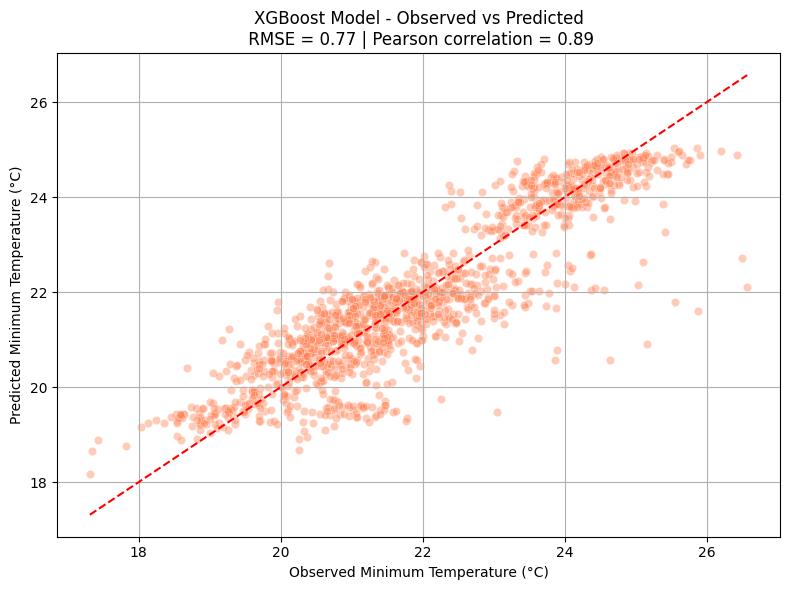

(np.float64(0.771802819599336), np.float64(0.8945560033792895))

In [44]:
model = XGBRegressor(**study.best_params)
X = X.reindex(sorted(X.columns), axis=1)
model.fit(X, y,sample_weight=df['sample_weight'])

tmin_resul = df.copy()

tmin_resul['Tmin_pred'] = model.predict(X)



# Calcular métricas
rmse = np.sqrt(mean_squared_error(tmin_resul['Tmin'], tmin_resul['Tmin_pred']))
pearson_corr, _ = pearsonr(tmin_resul['Tmin'], tmin_resul['Tmin_pred'])

# Graficar observados vs estimados
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x='Tmin', y='Tmin_pred', data=tmin_resul, alpha=0.4,color="#FF7F50")
plt.plot([tmin_resul['Tmin'].min(), tmin_resul['Tmin'].max()], [tmin_resul['Tmin'].min(), tmin_resul['Tmin'].max()], 'r--')
plt.xlabel("Observed Minimum Temperature (°C)")
plt.ylabel("Predicted Minimum Temperature (°C)")
plt.title(f"XGBoost Model - Observed vs Predicted\n RMSE = {rmse:.2f} | Pearson correlation = {pearson_corr:.2f}")
plt.grid(True)
plt.tight_layout()
plt.show()

rmse, pearson_corr

### Mejores resultados Xgboost

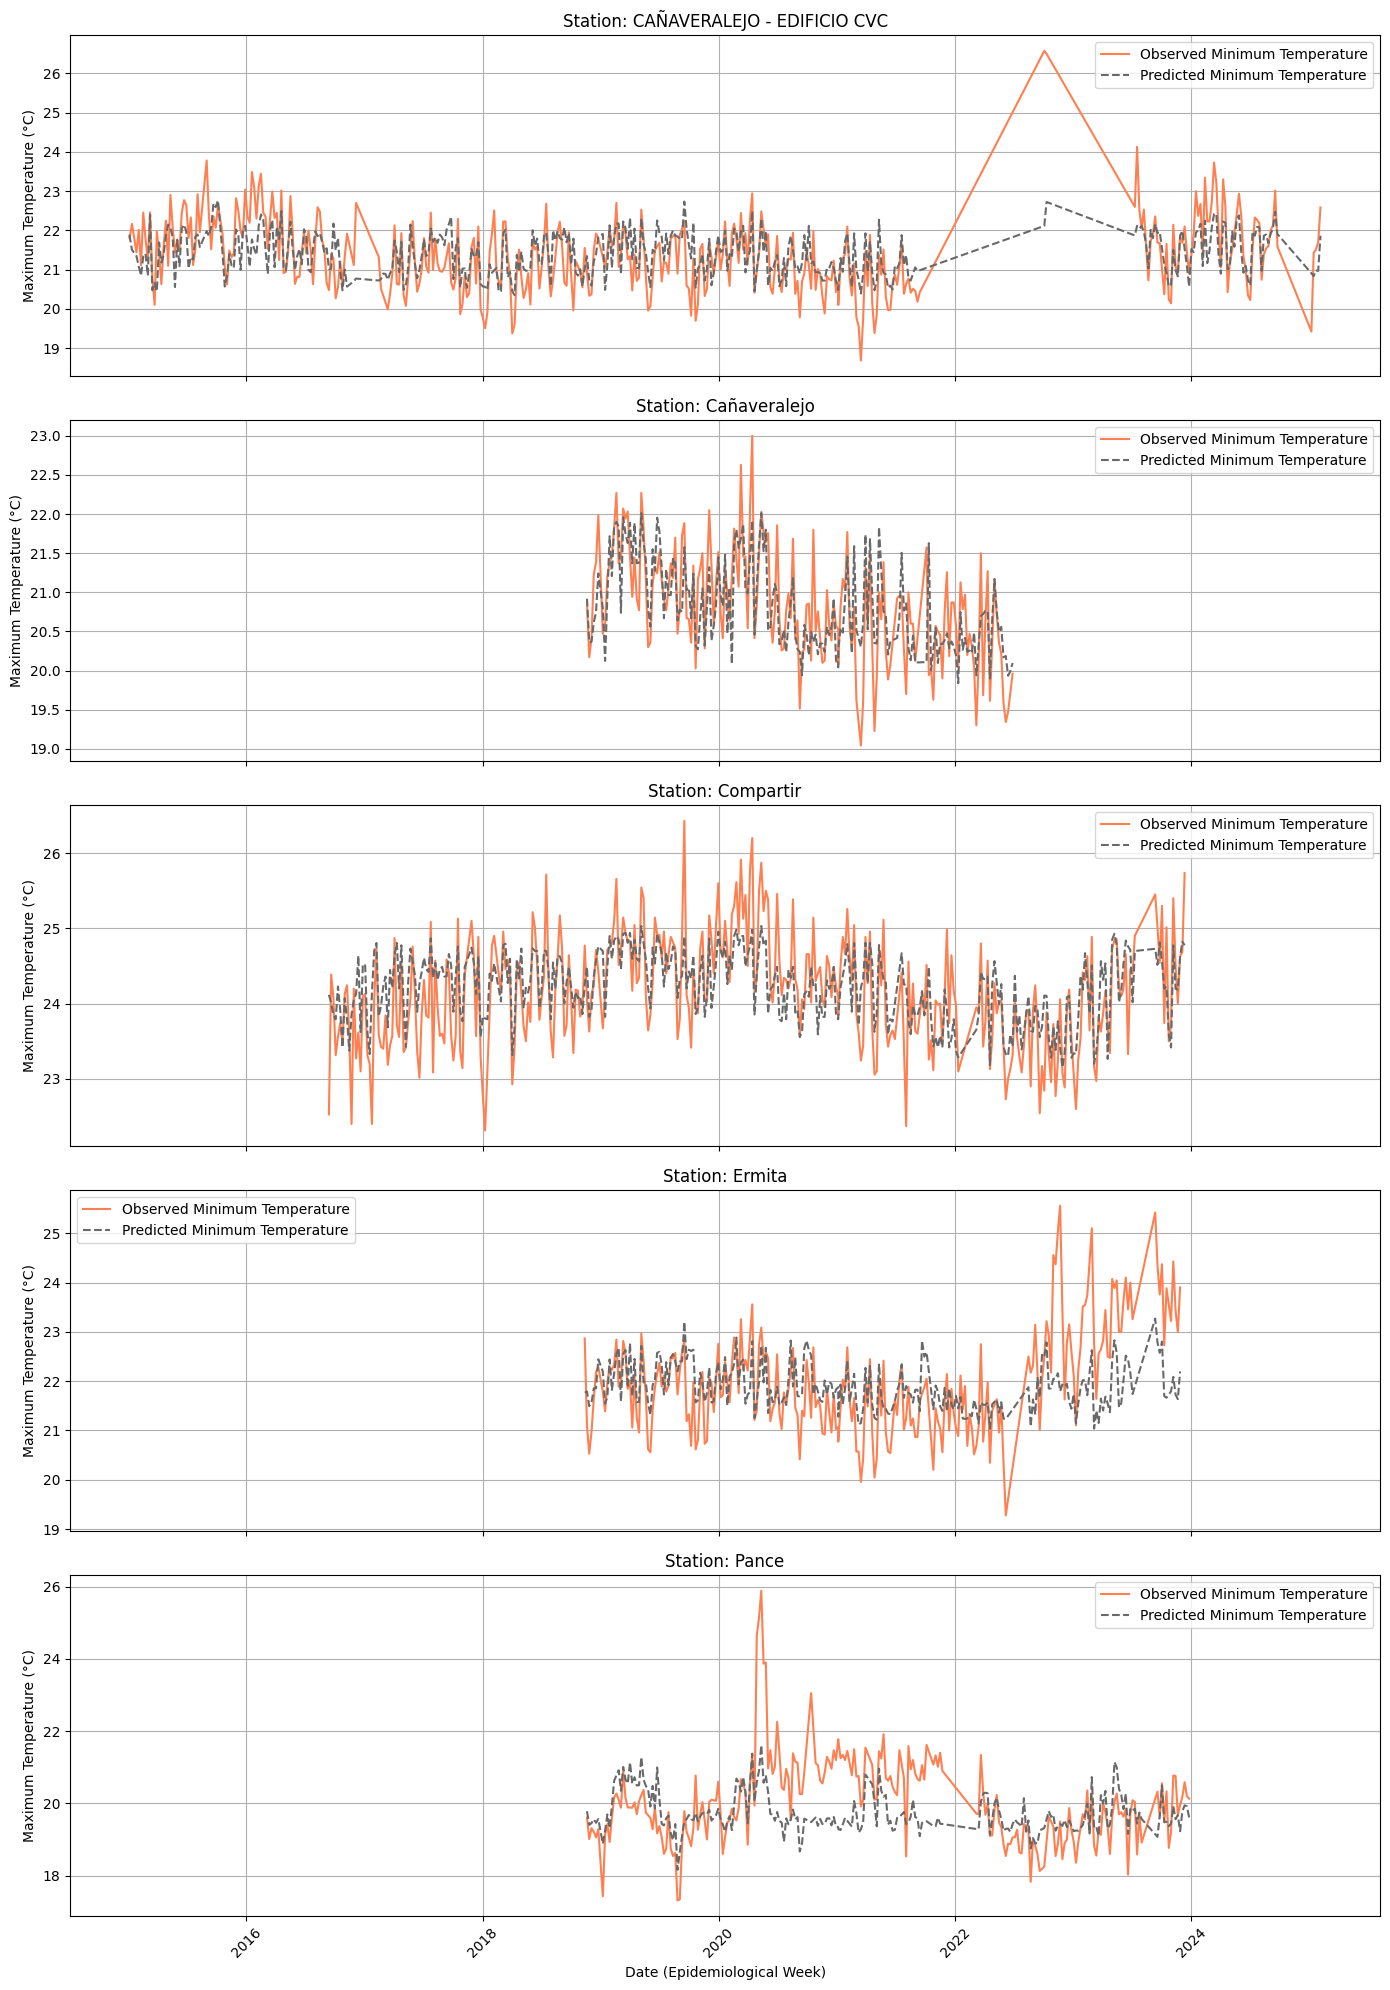

In [45]:
# Usar todos los datos disponibles para todas las estaciones (sin limitar a 50 por estación)
full_plot_data = tmin_resul.copy()
full_plot_data['Fecha'] = pd.to_datetime(full_plot_data['epi_week'] + '-1', format='%Y-%W-%w', errors='coerce')
full_plot_data = full_plot_data.dropna(subset=['Tmin', 'Tmin_pred', 'Fecha'])

# Obtener estaciones únicas
stations = full_plot_data['Estacion'].unique()

# Crear un gráfico por estación
fig, axes = plt.subplots(nrows=len(stations), ncols=1, figsize=(14, 4 * len(stations)), sharex=True)

# Asegurar que axes es iterable
if len(stations) == 1:
    axes = [axes]

# Generar los subgráficos
for ax, station in zip(axes, stations):
    data = full_plot_data[full_plot_data['Estacion'] == station]
    ax.plot(data['Fecha'], data['Tmin'], label='Observed Minimum Temperature', linestyle='-',color="#FF7F50")
    ax.plot(data['Fecha'], data['Tmin_pred'], label='Predicted Minimum Temperature', linestyle='--',color="#696969")
    ax.set_title(f'Station: {station}')
    ax.set_ylabel('Maximum Temperature (°C)')
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

plt.xlabel("Date (Epidemiological Week)")
plt.tight_layout()
plt.show()

## Shapply values Xgboost 

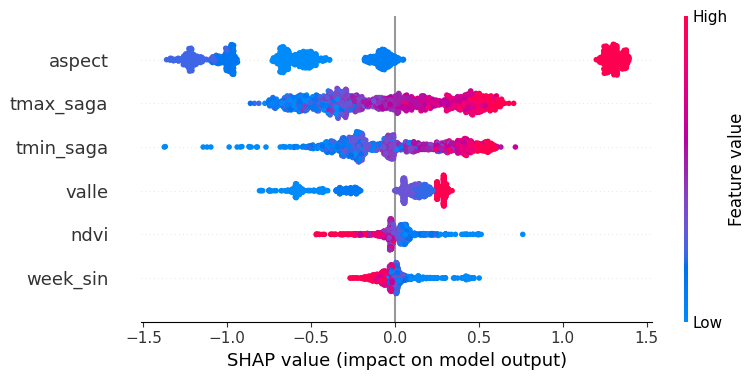

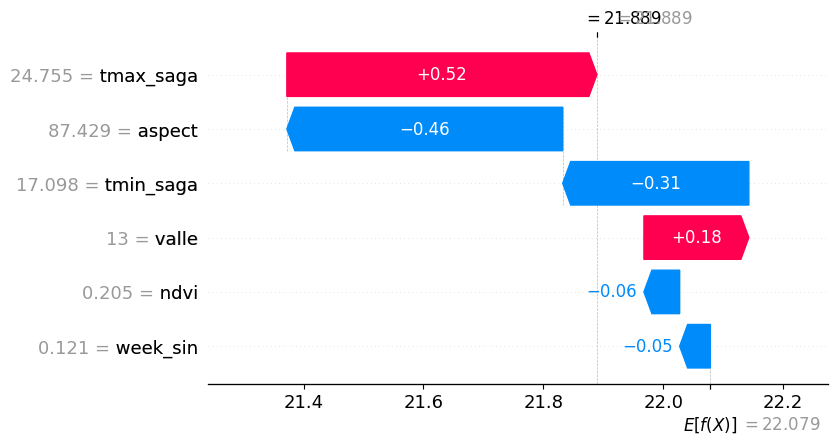

In [46]:
# Usar un subconjunto si hay muchos datos
X_sample = X  # opcional, para visualización más rápida

# Crear el objeto SHAP explainer
explainer = shap.Explainer(model)

# Calcular los valores SHAP
shap_values = explainer(X_sample)

# Visualización: resumen de importancia global
shap.summary_plot(shap_values, X_sample)

# Visualización: aportes en una predicción individual
shap.plots.waterfall(shap_values[0])

## Comparación linea base sesgo en media y varianza

In [47]:
tmin_resul.columns

Index(['Estacion', 'year', 'week', 'Tmin', 'Latitud', 'Longitud', 'epi_week',
       'tmax_saga', 'tmin_saga', 'slope', 'aspect', 'tpi', 'cumbre', 'valle',
       'rugosity', 'dem', 'ndvi', 'sample_weight', 'week_sin', 'week_cos',
       'Tmin_pred'],
      dtype='object')

In [48]:
assesment = tmin_resul[["Estacion","year","week","Tmin","tmin_saga","Tmin_pred"]]

# Calcular métricas
def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    corr, _ = pearsonr(y_true, y_pred)
    bias = np.mean(y_pred - y_true)
    var_ratio = np.var(y_pred) / np.var(y_true)
    return rmse, corr, bias, var_ratio


grouped_results = []

for station, group in assesment.groupby("Estacion"):
    metrics_saga = compute_metrics(group["Tmin"], group["tmin_saga"])
    metrics_xgb = compute_metrics(group["Tmin"], group["Tmin_pred"])
    improvement = [s - x for s, x in zip(metrics_saga, metrics_xgb)]
    
    for metric, saga_val, xgb_val, imp_val in zip(["RMSE", "Pearson r", "Bias (mean error)", "Variance Ratio"], metrics_saga, metrics_xgb, improvement):
        grouped_results.append({
            "Station": station,
            "Metric": metric,
            "SAGA_Lapserate": saga_val,
            "XGBoost": xgb_val,
            "Improvement": imp_val
        })

results_by_station_df = pd.DataFrame(grouped_results)

results_by_station_df

,Station,Metric,SAGA_Lapserate,XGBoost,Improvement
0,CAÑAVERALEJO - EDIFICIO CVC,RMSE,4.045934,0.696989,3.348945
1,CAÑAVERALEJO - EDIFICIO CVC,Pearson r,0.217427,0.677521,-0.460094
2,CAÑAVERALEJO - EDIFICIO CVC,Bias (mean error),-3.940366,0.026753,-3.967119
3,CAÑAVERALEJO - EDIFICIO CVC,Variance Ratio,0.056572,0.349673,-0.293101
4,Cañaveralejo,RMSE,3.252785,0.517320,2.735465
5,Cañaveralejo,Pearson r,0.347077,0.687906,-0.340829
6,Cañaveralejo,Bias (mean error),-3.185096,-0.011153,-3.173943
7,Cañaveralejo,Variance Ratio,0.093941,0.650815,-0.556874
8,Compartir,RMSE,6.023257,0.536988,5.486270
9,Compartir,Pearson r,0.387047,0.689017,-0.301970


In [49]:
## Guarda el  mejor modelo para tmax

dump(model, "D:/OneDrive - CGIAR/Desktop/downscaling/models/xgb_tmin.joblib")

['D:/OneDrive - CGIAR/Desktop/downscaling/models/xgb_tmin.joblib']